In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from tqdm.auto import tqdm

In [2]:
from darts import TimeSeries
from darts.metrics import mape, mase, rmse, mae, smape, mse

from darts.utils.missing_values import fill_missing_values

## MODWT functions

In [3]:
import numpy as np
import pdb
import pywt


def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
        Modification of 
            https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
    '''
    return np.flip(np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(np.flip(ker))))).astype(np.int).tolist()


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)

## Prepare Dataset

In [4]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "lsm" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False

print(param_dset_forecast)

48


In [5]:
import os
os.system('')
import pgzip
import pickle
import copy
import torch
import datetime

# path='Datasets/LondonSmartMeter' # if under experiments folder
path = './LondonSmartMeter'
seq_len = param_dset_lookback
pred_horz = param_dset_forecast
weather = param_trf_weather
timestamps = False
weather = False


if 'lsm_dict.pkl.pgz' not in os.listdir(path):
    subprocess.check_call('python ./LondonSmartMeter_hhour.py ./LondonSmartMeter lsm_dict.pkl')
if 'londonWeather.pkl.pgz' not in os.listdir(path):   
    raise ValueError

with pgzip.open(os.path.join(path,'lsm_dict.pkl.pgz'),'rb') as f:
    s_dict = pickle.load(f)
    


In [6]:
self_has_weather = weather
self_return_timestamps = timestamps

self_weather_dict = None
if self_has_weather:
    with pgzip.open(os.path.join(path,'londonWeather.pkl.pgz'),'rb') as f2:
        weather_dict = pickle.load(f2)

    self_weather_dict = weather_dict

#s_dict is dictionary as follows: { lclid: (start_timestamp,Tensor), ...}

#List to store the dataset indices corresponding to each household
self_household_idxs = [None]*len(s_dict)
#List to hold the split series
self_series = [None]*len(s_dict)
#These two lists will be converted to torch tensors
self_start_times = []
self_pred_starttimes = []
#These two lists stores the datetime format
self_start_times__ = []
#self.pred_starttimes__ = []

index_count = 0

# Enumerate all keys in dictionary -> lclid
for index, lclid in enumerate(s_dict.keys()):    
    start_time, s_tensor = s_dict[lclid]
    #start_time[0] = start_time[0]%400
    
    #pad_amt = (seq_len+pred_horz) - (len(s_tensor)%(seq_len+pred_horz))
    #s_tensor = torch.nn.functional.pad(s_tensor,pad = (pad_amt,0), value = torch.nan)
    
    #Split into chunks of seq_len+pred_horz length each
    s_tensors = s_tensor.split(seq_len+pred_horz)

    #Compute start timestamps for splits
    start_times = [None]*len(s_tensors)
    pred_starttimes = [None]*len(s_tensors)

    for i in range(len(start_times)):
        minutes_delta = 30*i*(seq_len + pred_horz)
        time_delta = datetime.timedelta(minutes=minutes_delta)
        new_start_time = start_time + time_delta
        start_times[i] = new_start_time

    # Reinitialised for computation of prediction start time
    minutes_delta = 30*seq_len
    time_delta = datetime.timedelta(minutes=minutes_delta)

    #Compute prediction start timestamps
    for i in range(len(pred_starttimes)):
        new_predtime = start_times[i] + time_delta
        pred_starttimes[i] = [new_predtime.year,
                              new_predtime.month,
                              new_predtime.day,
                              new_predtime.hour,
                              new_predtime.minute,
                              new_predtime.second]

    ''' 
    A shallow copy, li2, is created using copy.copy(), 
    preserving the top-level structure but sharing references to the inner lists. 
    A deep copy, li3, is created using copy.deepcopy(), resulting in a completely 
    independent copy of li1, including all nested elements
    '''
    
    start_times__ = copy.deepcopy(start_times)
    for i in range(len(start_times)):
        new_start_time = start_times[i]
        start_times[i] = [new_start_time.year,
                          new_start_time.month,
                          new_start_time.day,
                          new_start_time.hour,
                          new_start_time.minute,
                          new_start_time.second]

    #Remove last if length less than the others
    if s_tensors[-1].shape[0] < seq_len+pred_horz:
        s_tensors = s_tensors[:-1]
        start_times = start_times[:-1]
        pred_starttimes = pred_starttimes[:-1]
        start_times__ = start_times__[:-1]

    if len(s_tensors) == 0:
        self_series[index] = torch.empty(0)                    
    else:
        '''
        torch.stack()
        Concatenates a sequence of tensors along a new dimension.
        All tensors need to be of the same size.
        '''
        s_tensors = torch.stack(s_tensors)
        # Remove invalid (more than 4/5 (80%) of series is 0 or nan)
        s_tensors[s_tensors==0] = torch.nan # 0s are invalid too, replace with nan
        # Count those tensor index with less than 80% invalid
        sel = (( (s_tensors==0) | s_tensors.isnan()).sum(dim=-1) < (4*(seq_len+pred_horz)//5))
        s_tensors = s_tensors[sel]
        
        # Get start, prediction times for those with less than 80% nan
        start_times_ = [start_times[i] for i in range(len(start_times)) if sel[i]]
        pred_starttimes_ = [pred_starttimes[i] for i in range(len(pred_starttimes)) if sel[i]]
        _start_times__ = [ start_times__[i] for i in range(len(start_times__)) if sel[i]]
        
        self_series[index] = s_tensors
        if index==0:
            print("before series:", self_series[0].shape)
        self_start_times = self_start_times + start_times_
        if index==0:
            print("start_times_ after: ", start_times_)
            print("start_times after: ", start_times)
        self_pred_starttimes = self_pred_starttimes + pred_starttimes_
        self_start_times__ = self_start_times__ + _start_times__

    if len(s_tensors) == 0:
        self_household_idxs[index] = []
    else:
        self_household_idxs[index] = list(range(index_count,index_count+len(s_tensors)))
        index_count = index_count + len(s_tensors)
        
print("before concat series:", len(self_series))
print("before concat series:", self_series[0].shape)
# Concat all households series but retain 1680 seq_len predictions
self_series = torch.cat(self_series,dim=0).unsqueeze(-1)
print("before normalization series:", self_series.shape)

self_start_times = torch.tensor(self_start_times,dtype = torch.long)
self_pred_starttimes = torch.tensor(self_pred_starttimes,dtype = torch.long)

#self.series[:,:seq_len] = self.series[:,:seq_len].nan_to_num(nan=0.,posinf=0.,neginf=0.)

#Series normalization
smin = self_series.nan_to_num(nan=torch.finfo(self_series.dtype).max).amin(dim=-2,keepdim=True)
smax = self_series.nan_to_num(nan=torch.finfo(self_series.dtype).min).amax(dim=-2,keepdim=True)
# Normalize over dimension -2, which is seq_len + prediction len
self_series = (self_series - smin.broadcast_to(self_series.shape))/(smax-smin+1e-10).broadcast_to(self_series.shape)

print("total series shape: ", self_series.shape)


if self_has_weather:
    #Weather series normalization
    #Only dimensions 0, 3, 4, 5, 6, 7 needs normalization
    wdmin = self_weather_dict['tensor'].nan_to_num(nan=torch.finfo(self_weather_dict['tensor'].dtype).max).amin(dim=-2,keepdim=True)
    wdmax = self_weather_dict['tensor'].nan_to_num(nan=torch.finfo(self_weather_dict['tensor'].dtype).min).amax(dim=-2,keepdim=True)
    self_weather_dict['tensor'] = (self_weather_dict['tensor'] - wdmin.broadcast_to(self_weather_dict['tensor'].shape))\
        /(wdmax-wdmin + 1e-10).broadcast_to(self_weather_dict['tensor'].shape)

    self_weather_dict['tensor'] = self_weather_dict['tensor'].type(torch.float32)

self_length = len(self_series)
self_seq_len = seq_len
self_pred_horz = pred_horz

before series: torch.Size([14, 1680])
start_times_ after:  [[2012, 10, 12, 0, 30, 0], [2012, 11, 16, 0, 30, 0], [2012, 12, 21, 0, 30, 0], [2013, 1, 25, 0, 30, 0], [2013, 3, 1, 0, 30, 0], [2013, 4, 5, 0, 30, 0], [2013, 5, 10, 0, 30, 0], [2013, 6, 14, 0, 30, 0], [2013, 7, 19, 0, 30, 0], [2013, 8, 23, 0, 30, 0], [2013, 9, 27, 0, 30, 0], [2013, 11, 1, 0, 30, 0], [2013, 12, 6, 0, 30, 0], [2014, 1, 10, 0, 30, 0]]
start_times after:  [[2012, 10, 12, 0, 30, 0], [2012, 11, 16, 0, 30, 0], [2012, 12, 21, 0, 30, 0], [2013, 1, 25, 0, 30, 0], [2013, 3, 1, 0, 30, 0], [2013, 4, 5, 0, 30, 0], [2013, 5, 10, 0, 30, 0], [2013, 6, 14, 0, 30, 0], [2013, 7, 19, 0, 30, 0], [2013, 8, 23, 0, 30, 0], [2013, 9, 27, 0, 30, 0], [2013, 11, 1, 0, 30, 0], [2013, 12, 6, 0, 30, 0], [2014, 1, 10, 0, 30, 0]]
before concat series: 5561
before concat series: torch.Size([14, 1680])
before normalization series: torch.Size([97143, 1680, 1])
total series shape:  torch.Size([97143, 1680, 1])


In [7]:
dat = self_series[:1334]

print(dat.shape)
# alpha=0.6667

alpha = 0.6
beta = 0.8


train_set = dat[:int(dat.shape[0]*alpha),:,:]
val_set = dat[int(dat.shape[0]*alpha):int(dat.shape[0]*beta),:,:]
test_set = dat[int(dat.shape[0]*beta):,:,:]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

torch.Size([1334, 1680, 1])
torch.Size([800, 1680, 1])
torch.Size([267, 1680, 1])
torch.Size([267, 1680, 1])


## Import Models for comparison

In [8]:
#Importing the testing models
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    VARIMA,
    BATS,
    TBATS,
    StatsForecastAutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FourTheta,
    FFT,
    NBEATSModel,
    TFTModel,
    RNNModel,
    TransformerModel,
)

In [9]:
def eval_model(model, train, val, f=None ):
    model.fit(train)
    forecast = model.predict(len(val))
    mseRes = mse(val, forecast)
    rmseRes = rmse(val, forecast)
    # mapeRes = mape(val, forecast)
    maeRes = mae(val, forecast)
    smapeRes = smape(val, forecast)
    # maseRes = mase(val, forecast,train)
    
    # print('model {} obtains MSE: {:.6f}'.format(model,mseRes))
    # print('model {} obtains RMSE: {:.6f}'.format(model,rmseRes))
    # # print('model {} obtains MAPE: {:.6f}'.format(model,mapeRes ))
    # print('model {} obtains MAE: {:.6f}'.format(model, maeRes))
    # print('model {} obtains SMAPE: {:.6f}'.format(model,smapeRes ))
    # print('model {} obtains MASE: {:.6f}'.format(model,maseRes ))

    return forecast, mseRes, rmseRes, maeRes, smapeRes

## Prepare Data

In [10]:
train_set_squeeze = train_set.squeeze(-1)
# print(train_set_squeeze.shape)
train_np = train_set_squeeze.numpy()
# print((type(train_np)))
train_series = np.nan_to_num(train_np[:])

val_set_squeeze = val_set.squeeze(-1)
# print(train_set_squeeze.shape)
val_np = val_set_squeeze.numpy()
val_series = np.nan_to_num(val_np[:])

test_set_squeeze = test_set.squeeze(-1)
# print(train_set_squeeze.shape)
test_np = test_set_squeeze[:,:param_dset_lookback].numpy()
test_series = np.nan_to_num(test_np)

print(test_series.shape)

(267, 1632)


In [11]:
train_series = np.nan_to_num(train_np[:800])
val_series = np.nan_to_num(val_np[:])
test_series = np.nan_to_num(test_np[:])

train_set_series = []
val_set_series = []
test_set_series = []


for i in tqdm(range(len(train_series)), total=len(train_series), desc="Series Conversion", position=1, leave=True):
    train = []
    nb_time = len(train_series[i])
    
    wt = modwt(train_series[i], 'db2', int(np.log(len(train_series[i]))))
    for j in range(len(wt)):
        
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[j]))
        
        wt_df_train = wt_df
        train.append(wt_df_train)

    train_set_series.append(train)

for i in tqdm(range(len(val_series)), total=len(val_series), desc="Series Conversion", position=1, leave=True):
    val = []
    nb_time = len(val_series[i])
    
    wt = modwt(val_series[i], 'db2', int(np.log(len(val_series[i]))))
    for j in range(len(wt)):
        
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[j]))
        
        wt_df_val = wt_df
        val.append(wt_df_val)

    val_set_series.append(val)

for i in tqdm(range(len(test_series)), total=len(test_series), desc="Series Conversion", position=1, leave=True):
    test = []
    nb_time = len(test_series[i])
    
    wt = modwt(test_series[i], 'db2', int(np.log(len(test_series[i]))))
    for j in range(len(wt)):
        
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[j]))
        
        wt_df_test = wt_df
        test.append(wt_df_test)

    test_set_series.append(test)


Series Conversion:   0%|          | 0/800 [00:00<?, ?it/s]

Series Conversion:   0%|          | 0/267 [00:00<?, ?it/s]

Series Conversion:   0%|          | 0/267 [00:00<?, ?it/s]

In [12]:
# Due to TimeSeries object, cannot use np.array
# Current shape: 100,7,816 -> 7 * 100,816
train_emb = []
val_emb = []
test_emb = []

for i in range(len(train_set_series[0])):
    train_emb_temp = [t[i] for t in train_set_series]
    train_emb.append(train_emb_temp)

for i in range(len(val_set_series[0])):
    val_emb_temp = [s[i] for s in val_set_series]
    val_emb.append(val_emb_temp)

for i in range(len(test_set_series[0])):
    test_emb_temp = [s[i] for s in test_set_series]
    test_emb.append(test_emb_temp)

print(len(train_emb))
print(len(val_emb))
print(len(test_emb))

8
8
8


In [13]:
# for i in range(len(train_emb)):
#     transformers = TransformerModel(
#     input_chunk_length=50,
#     output_chunk_length=1,
#     batch_size=64,
#     n_epochs=20,
#     model_name="modwt_pred_transformer_{}_{}_{}".format(param_dset_lookback_weeks, param_dset_forecast, i),
#     nr_epochs_val_period=2,
#     #d_model=16,
#     #nhead=8,
#     d_model=64,
#     nhead=32,
#     num_encoder_layers=2,
#     num_decoder_layers=2,
#     dim_feedforward=128,
#     dropout=0.1,
#     activation="relu",
#     random_state=42,
#     save_checkpoints=True,
#     force_reset=True,
#     # pl_trainer_kwargs = {"accelerator": "gpu", 
#     #                    "gpus": -1, 
#     #                    "auto_select_gpus": True},
#     pl_trainer_kwargs = {"callbacks": [my_stopper]}
#     )

# for i in range(len(train_emb)):
#     print(id(i))

In [15]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Train models based on different values of wavelet transform
prediction = []
models_transformers = []
for i in range(len(train_emb)):
    # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
    # a period of 2 epochs (`patience`)
    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=2,
        min_delta=0.0,
        mode='min',
    )
        
    transformers = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=64,
    n_epochs=20,
    model_name="London_modwt_pred_transformer_{}_{}_{}".format(param_dset_lookback_weeks, param_dset_forecast, i),
    nr_epochs_val_period=1,
    d_model=16,
    nhead=8,
    # d_model=64,
    # nhead=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    # pl_trainer_kwargs = {"accelerator": "gpu", 
    #                    "gpus": -1, 
    #                    "auto_select_gpus": True},
    pl_trainer_kwargs = {"callbacks": [my_stopper]}
    )
    
    transformers.fit(series= train_emb[i], val_series= val_emb[i], verbose=True)
    # print('seriesList = ', Series_List_emb[i])
    print('nb-time-nforecast = ',nb_time-param_dset_forecast)

    # best_model = TransformerModel.load_from_checkpoint(
    #     model_name="transformer"+str(i), best=True
    # )
    transformers.save("MODWT_transformer_model.pt")
    # best_val_model = TransformerModel.load("MODWT_transformer_model.pt")
    best_val_model = TransformerModel.load_from_checkpoint("London_modwt_pred_transformer_{}_{}_{}".format(param_dset_lookback_weeks, param_dset_forecast, i))

    pred_series = best_val_model.predict(n=param_dset_forecast, series=test_emb[i])

    prediction.append(pred_series)
    models_transformers.append(transformers)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True


nb-time-nforecast =  1584


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


nb-time-nforecast =  1584


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 17    
------------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

nb-time-nforecast =  1584


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [19]:
# Due to TimeSeries object, cannot use np.array
# Current shape: 7 * 100,816-> 100,7,816
new_pred = []

for i in range(len(prediction[0])):
    pred_temp = [t[i] for t in prediction]
    new_pred.append(pred_temp)

print(len(new_pred))
print(len(new_pred[0]))

267
8


In [20]:
full_result = []

for series_num in range(len(new_pred)):
    prediction_tmp = new_pred[series_num][0].pd_dataframe()
    
    for i in range(1,len(new_pred[series_num])):
        prediction_tmp[i] = new_pred[series_num][i].pd_dataframe()
    
    res = imodwt(prediction_tmp.transpose().to_numpy(),'db2')
    full_result.append(TimeSeries.from_values(res))

# print(full_result)

In [21]:
# import torch
# test_actual = test_set_squeeze.numpy()
# test_actual = test_actual[:200,param_dset_lookback:]

# test_predict = np.array(full_result)
# test_predict = torch.from_numpy(test_predict)
# test_actual = torch.from_numpy(test_actual)

# test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

# test_mae = (test_predict-test_actual).abs_().nanmean()

# mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

# print(test_rmse, test_mae, mape)

In [22]:
test_actual = test_set_squeeze.numpy()
test_actual_series = np.nan_to_num(test_actual[:,param_dset_lookback:])

actual = []
for i in range(len(test_actual_series)):
    actual.append(TimeSeries.from_values(test_actual_series[i]))

pred = full_result
print(np.mean(mse(actual,pred)), np.mean(rmse(actual,pred)),np.mean(mae(actual,pred)), np.mean(smape(actual,pred))) #, mape(actual,pred)

0.02158238909826861 0.1352525259264865 0.10410310656247672 84.7849544675197


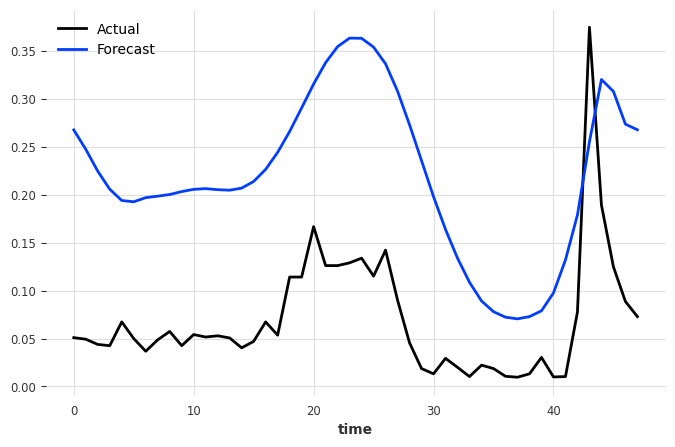

In [23]:
plt.figure(figsize=(8, 5))
actual[1].plot(label="Actual")
pred[1].plot(label="Forecast")
plt.legend()